# In this notebook we test and evaluate RoBERTa with finetune.

In [1]:
import pandas as pd
from tqdm import tqdm 
from pathlib import Path
import csv
import pprint
import numpy as np

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Path to data folder

DATA_DIR = Path('../../data')

# Load data and model

In [2]:
# load test data from action_test.cev.gz file

df_action_name = (
    pd.read_csv(DATA_DIR / 'test.csv.gz', index_col = [0])
    .sort_values(by=['names_number'],ascending=False)
    .head(100)
)

#df_action_name = df_action_name.loc[(df_action_name['names_number'] >= 1000)]
df_action_name

,action,name_official,description_official,names_users,names_number
0,actions/upload-artifact,Upload a Build Artifact,Upload a build artifact that can be used by su...,"upload dh-make-golang test run as artifact,upl...",736
1,actions/cache,Cache,Cache artifacts like dependencies and build ou...,"cache conan data,handle yarn cache,restore nod...",363
2,actions/checkout,Checkout,Checkout a Git repository at a particular version,"checkout ref commit,checkout the source code,c...",359
3,actions/download-artifact,Download a Build Artifact,Download a build artifact that was previously ...,"download external libs,download ${{ matrix.nam...",228
4,actions/upload-release-asset,Upload a Release Asset,Upload a release asset to an existing release ...,"upload node modules package,uploading release ...",218
...,...,...,...,...,...
92,pypa/cibuildwheel,cibuildwheel,Installs and runs cibuildwheel on the current ...,"build wheels for linux,build macos wheels,buil...",4
90,shogo82148/actions-goveralls,actions-goveralls,Coveralls GitHub Action with Go integration po...,"report coverage,send goveralls coverage,upload...",4
89,r0adkll/sign-android-release,Sign Android release,An action to sign an Android release APK or AAB,"sign proprietary app bundle,sign helloxr openg...",4
88,azure/cli,Azure CLI Action,Automate your GitHub workflows using Azure CLI...,"get windows helper ips,create windows helper v...",4


In [6]:
# initialize the RoBERTa based model. 

import torch
from transformers import (WEIGHTS_NAME, AdamW, get_linear_schedule_with_warmup,
                          BertConfig, BertForMaskedLM, BertTokenizer,
                          GPT2Config, GPT2LMHeadModel, GPT2Tokenizer,
                          OpenAIGPTConfig, OpenAIGPTLMHeadModel, OpenAIGPTTokenizer,
                          RobertaConfig, RobertaModel, RobertaTokenizer,
                          DistilBertConfig, DistilBertForMaskedLM, DistilBertTokenizer)

MODEL_CLASSES = {
    'gpt2': (GPT2Config, GPT2LMHeadModel, GPT2Tokenizer),
    'openai-gpt': (OpenAIGPTConfig, OpenAIGPTLMHeadModel, OpenAIGPTTokenizer),
    'bert': (BertConfig, BertForMaskedLM, BertTokenizer),
    'roberta': (RobertaConfig, RobertaModel, RobertaTokenizer),
    'distilbert': (DistilBertConfig, DistilBertForMaskedLM, DistilBertTokenizer)
}


config_class, model_class, tokenizer_class = MODEL_CLASSES['roberta']

config = config_class.from_pretrained("roberta-base")
tokenizer = tokenizer_class.from_pretrained("roberta-base")
encoder = model_class.from_pretrained("roberta-base", config=config)


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
# load model's parameters from checkpoint.

from model import Model

#input_dir = './saved_models/action_model_finetuned/checkpoint-best-f1/model.bin'

args = ''

encoder=Model(encoder,config,tokenizer,args)
#encoder.load_state_dict(torch.load(input_dir))

# Text embedding 

In [8]:
def phrase_tokenization(phrase, tokenizer, max_token_length):
    
    '''This function tokenize the phrases into ids'''
    
    phrase_tokens = tokenizer.tokenize(phrase)
    phrase_tokens = phrase_tokens[:max_token_length-2]
    phrase_tokens = [tokenizer.cls_token]+phrase_tokens+[tokenizer.sep_token]
    
    phrase_ids=tokenizer.convert_tokens_to_ids(phrase_tokens)
    padding_length = max_token_length - len(phrase_ids)
    phrase_ids+=[tokenizer.pad_token_id]*padding_length
    
    return phrase_ids

def phrases_embedding(list_phrases, tokenizer, encoder, max_token_length = 128):
    
    '''This function tansfer phrases' ids into tensors and apply our model's encoder to embed the phrases' ids into high-dimensional vectors'''
    
    max_token_length = max_token_length
    #print(max_token_length)
    
    ##### -----------> Here is a problem: what about the descriptions with more than 25 words?

    
    phrases_tokens = [phrase_tokenization(phrase, tokenizer, max_token_length) for phrase in list_phrases]
    
    phrases_tensors = [torch.tensor(token) for token in phrases_tokens]
    
    phrases_embeddings = [encoder.encode(input_ids=phrase.unsqueeze(0)) for phrase in tqdm(phrases_tensors, position=0, leave=True)]
    

    return phrases_embeddings

In [9]:
# extract test data from dataframe 'df_action_name'.

list_actions = df_action_name.to_dict('records')


list_names = [str(action['name_official']).lower() for action in list_actions]
list_descriptions = [str(action['description_official']).lower() for action in list_actions]
list_names_users = [list(action['names_users'].lower().split(',')) for action in list_actions]
#list_names_users = [list(set(action['names_users'].lower().split(','))) for action in list_actions]

list_names_users = [[name.strip() for name in names] for names in list_names_users]

In [10]:
# show data.

print(f'Top {len(list_names)} most frequently applied GitHub Actions has been selected! \n' )
n_example = 0
print(f'e.g. Action number {n_example}: \n')
print(f'Official name: \t\t {list_names[n_example]}')
print(f'Official description:\t {list_descriptions[n_example]} \n')
print(f'With {len(list_names_users[n_example])} User-assigned names, give 10 examples:')
pprint.pprint(list_names_users[n_example][:10])

Top 100 most frequently applied GitHub Actions has been selected! 

e.g. Action number 0: 

Official name: 		 upload a build artifact
Official description:	 upload a build artifact that can be used by subsequent workflow steps 

With 736 User-assigned names, give 10 examples:
['upload dh-make-golang test run as artifact',
 'upload windows binary',
 'upload ui tar',
 'archive ruby package artifact [ruby-pkg_2.7_ubuntu-18.04_jemalloc] to github',
 'upload debug log test files',
 'publish artifact (debug/64)',
 'publish artifact - x86_64-w64-mingw32',
 'upload src distribution',
 'upload cloudprober binary zip',
 'upload gba.emu artifact']


In [11]:
# embed test data. (official names + official descriptions)

block_size = 128

names_official_embeddings = phrases_embedding(list_names, tokenizer, encoder, block_size)
descriptions_official_embeddings = phrases_embedding(list_descriptions, tokenizer, encoder, block_size)

# different way to aggregate the embedding of names and descriptions: Arithmetic mean & L2-Norm

combined_official_embeddings = [torch.div((name+description),2) for name,description in zip(names_official_embeddings,descriptions_official_embeddings)]
combined_official_embeddings_l2 = [torch.sqrt(torch.square(name)+torch.square(description)) for name,description in zip(names_official_embeddings,descriptions_official_embeddings)]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.08it/s]


In [12]:
# embed test data. (user-assigned names)

list_names_users_embeddings = [phrases_embedding(name[:10],tokenizer, encoder, block_size) for name in list_names_users]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.33it/s]


# Model testing and evaluation

In [13]:
def predict(list_names_users_embeddings,official_embeddings,top_n = 3):
    
    '''
    This function calculates the cosine similarities between each embedding vector of the user-assigned names 
    and every vectors of official name/description, etc., then sorts the results from the highest value to the lowest value
    along with their indexes(labels), finally returns the top_n indexes(labels) as the output suggested_labels.
    '''

    
    predicted_labels = []

    for names_users in tqdm(list_names_users_embeddings, position=0, leave=True):
        predicted_label= []

        for name_user in names_users:
            #print(name_user.shape)
            #print(names_official_embeddings[0].shape)
            cos_sim = [[F.cosine_similarity(name_official[0].view(1,-1).float(), name_user.view(1,-1).float()),index] for index,name_official in enumerate(names_official_embeddings)]
            
            predicted_label.append(sorted(cos_sim,reverse=True)[:top_n])


        predicted_labels.append(predicted_label)
        
    suggested_labels = [[[label[1] for label in labels] for labels in one_predicted_labels] for one_predicted_labels in predicted_labels]
    
    return suggested_labels


def predict_cs(list_names_users_embeddings,names_official_embeddings,descriptions_official_embeddings,top_n = 3):
    
    '''
    This function is slightly different from the previous predict function. It combines the cos_similarities calculated from 
    (user-assigned names, official names) & (user-assigned names, descriptions) by taking the arithmetic mean value.
    '''
    
    predicted_labels = []

    for names_users in tqdm(list_names_users_embeddings, position=0, leave=True):
        predicted_label= []

        for name_user in names_users:
            cos_sim_name = [F.cosine_similarity(name_official[0].view(1,-1).float(), name_user.view(1,-1).float()) for name_official in names_official_embeddings]
            cos_sim_description = [F.cosine_similarity(description_official[0].view(1,-1).float(), name_user.view(1,-1).float()) for description_official in descriptions_official_embeddings]
            #print(cos_sim_name[0])
            #break
            divide = lambda x,y: (x+y) /2
            cos_sim = [[divide(cos_sim_name[index],cos_sim_description[index]),index] for index in range(len(cos_sim_name))]
            
            predicted_label.append(sorted(cos_sim,reverse=True)[:top_n])


        predicted_labels.append(predicted_label)
        
    suggested_labels = [[[label[1] for label in labels] for labels in one_predicted_labels] for one_predicted_labels in predicted_labels]
    
    return suggested_labels

In [14]:
def top_n_acc(predicted_labels, action_index):
    '''
    This function calculates the success rate per action,
    the output is positive if the real label is predicted correctly in the top_n suggestions.
    (the first suggestion doesn't have to be the right one if top_n != 1)
    '''
    return len([n for n in predicted_labels if action_index in n]) / len(predicted_labels)

def coverage_rate_(predicted_labels):
    '''
    This function calculates the coverage rate of the model's suggestions.
    '''
    covered_names = []

    for action in predicted_labels:
        all_name_per_action = []
        for name in action:
            all_name_per_action += name
        
        all_name_per_action = list(set(all_name_per_action))
        #print(len(all_name_per_action))
        covered_names += all_name_per_action
    
    covered_names = list(set(covered_names))   
    coverage = round(len(covered_names)/100,3)

    return coverage

def find_false_cases(predicted_labels):
    '''
    This function finds the failed cases, i.e. the expected action is not been suggested by the model.
    '''
    false_cases = []
    for action_index,predicted_labels_action in enumerate(predicted_labels):
        
        false_cases_action = []
    
        for name_index, labels in enumerate(predicted_labels_action):
            if action_index not in labels:
                false_cases_action.append([action_index,name_index])

        if false_cases_action:
            false_cases.append(false_cases_action)
    
    return false_cases
    
def average_success_rate(suggested_labels, prediction_type):
    '''
    This function calculates the average success rate of the model, and prints it.
    '''
    acc = []
    #false_cases = []
    for action_index,predicted_labels in enumerate(suggested_labels):
        acc.append(top_n_acc(predicted_labels, action_index))
        #false_cases_action = find_false_cases(predicted_labels, action_index)
        #if false_cases_action:
        #    false_cases.append(false_cases_action)

    average_acc = round(sum(acc)/len(acc),3)
    print(prediction_type+'.')
    #print(f'best acc among actions:{max(acc)}')
    #print(f'average acc:{average_acc} \n' )

    return average_acc

def count_number(list_samples):
    '''
    This function counts the overall number of samples in a list of list.
    It's been used to count the failed samples and also the number of samples existing in test set.
    '''
    all_samples = []
    for samples in list_samples:
        all_samples += samples

    return len(all_samples)

In [15]:
# compute the suggested labels in different ways.

import torch.nn.functional as F

top_n = 1

suggested_labels_combined_embedding = predict(list_names_users_embeddings, combined_official_embeddings,top_n)
#suggested_labels_combined_cs = predict_cs(list_names_users_embeddings,names_official_embeddings,descriptions_official_embeddings,top_n)
#suggested_labels_combined_embedding_l2 = predict(list_names_users_embeddings, combined_official_embeddings_l2,top_n)
#suggested_labels_name = predict(list_names_users_embeddings,names_official_embeddings,top_n)
#suggested_labels_description = predict(list_names_users_embeddings,descriptions_official_embeddings,top_n)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:37<00:00,  2.70it/s]


In [16]:
success_rate = average_success_rate(suggested_labels_combined_embedding, 'Combine names and descriptions embedding before calculating CS')
#show_performance(suggested_labels_combined_cs, 'combine cosine similarity(CS)')
#show_performance(suggested_labels_combined_embedding_l2, 'combine names and descriptions embedding using L2-norm ')
#show_performance(suggested_labels_name, 'only use names')
#show_performance(suggested_labels_description, 'only use descriptions')
coverage_rate = coverage_rate_(suggested_labels_combined_embedding)
false_cases = find_false_cases(suggested_labels_combined_embedding)

n_fail = count_number(false_cases)
n_predict = count_number([name[:10] for name in list_names_users])

print(f'Success rate: {success_rate}')
print(f'Coverage rate: {coverage_rate}')
print(f'Failure: {len(false_cases)}/100 actions has at least one failed suggestion; {n_fail}/{n_predict} fail attempts in total.')

Combine names and descriptions embedding before calculating CS.
Success rate: 0.11
Coverage rate: 0.87
Failure: 100/100 actions has at least one failed suggestion; 697/784 fail attempts in total.


# Failure investigation

In [103]:
def predict_single(name, tokenizer, names_official_embeddings, list_actions, max_token_length = 128, top_n = 3):
    
    name_tokens = phrase_tokenization(name, tokenizer, max_token_length)
    #print(name_tokens)
    name_tensors = torch.tensor(name_tokens)
    name_embedding = encoder.encode(input_ids=name_tensors.unsqueeze(0))
    #print(name_embedding.shape)
    

    cos_sim = [[F.cosine_similarity(name_official[0].view(1,-1).float(), name_embedding.view(1,-1).float()),index] for index,name_official in enumerate(names_official_embeddings)]
            
    predicted_label = sorted(cos_sim,reverse=True)[:top_n]

    suggested_labels = [labels[1] for labels in predicted_label]
    
    print(f'Top {top_n} suggested GitHub Actions:')
    
    for i in range(len(suggested_labels)):
        print(f'{i}: {list_actions[suggested_labels[i]]["action"]}')
    
    return 

#predict_single('Download a Build Artifact',tokenizer,names_official_embeddings,list_actions,128,5)

In [104]:
false_cases[:10]

[[[0, 1]],
 [[1, 8]],
 [[3, 0], [3, 4], [3, 8]],
 [[6, 1], [6, 6], [6, 9]],
 [[7, 0], [7, 1], [7, 2], [7, 5], [7, 7], [7, 8]],
 [[9, 0], [9, 2], [9, 3], [9, 4], [9, 5], [9, 7], [9, 9]],
 [[12, 1], [12, 2], [12, 3], [12, 4], [12, 5], [12, 9]],
 [[13, 1], [13, 2], [13, 3], [13, 4], [13, 7], [13, 8], [13, 9]],
 [[14, 0], [14, 2], [14, 4], [14, 5], [14, 6], [14, 8]],
 [[15, 3], [15, 4], [15, 7]]]

In [106]:
n_action, n_name = 0,1

print(f"One failure example(user-assigned name):'{list_names_users[n_action][n_name]}'\n")
print(f"Expect action: {list_actions[n_action]['action']}\n")

predict_single(list_names_users[0][1],tokenizer,names_official_embeddings,list_actions,128,top_n)

One failure example(user-assigned name):'upload windows binary'

Expect action: actions/upload-artifact

Top 1 suggested GitHub Actions:
0: actions/upload-release-asset


# Vector visualization

In [17]:
list_names_users_visualization = [phrases_embedding(name[:30],tokenizer, encoder, block_size) for name in list_names_users[30:60]]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.65it/s]


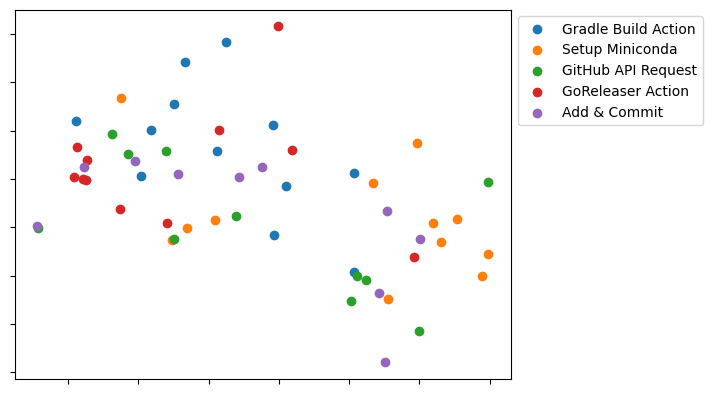

In [18]:
# data visualization.
from sklearn.manifold import TSNE

data_visualization = list_names_users_visualization[9:14]
group_tensors = [torch.cat(inner_list, dim=0) for inner_list in data_visualization]

with torch.no_grad():
    flattened_data = torch.cat(group_tensors, dim=0)
    flattened_data = flattened_data.view(flattened_data.size(0), -1).numpy()

labels = np.repeat(np.arange(len(data_visualization)), [len(inner_list) for inner_list in data_visualization])


# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
embedded_data = tsne.fit_transform(flattened_data)

# plot the embedded data with different colors for each group
for group_idx in np.unique(labels):
    group_mask = (labels == group_idx)
    plt.scatter(embedded_data[group_mask, 0], embedded_data[group_mask, 1], label=f"{list_actions[39+group_idx]['name_official']}")

plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
ax = plt.gca()
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])

plt.show()